In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kavanabm","key":"32d6c6e18ddaf2ec3e094108b64c435c"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d osamajalilhassan/bone-fracture-dataset


Dataset URL: https://www.kaggle.com/datasets/osamajalilhassan/bone-fracture-dataset
License(s): unknown
 65% 112M/173M [00:00<00:00, 1.16GB/s]
100% 173M/173M [00:00<00:00, 1.06GB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/bone-fracture-dataset.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg16
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score
import seaborn as sns
import cv2
import pandas as pd
import time

In [7]:
DATADIR ='/content/BoneFractureDataset'
CATEGORIES = ['fractured','not_fractured']

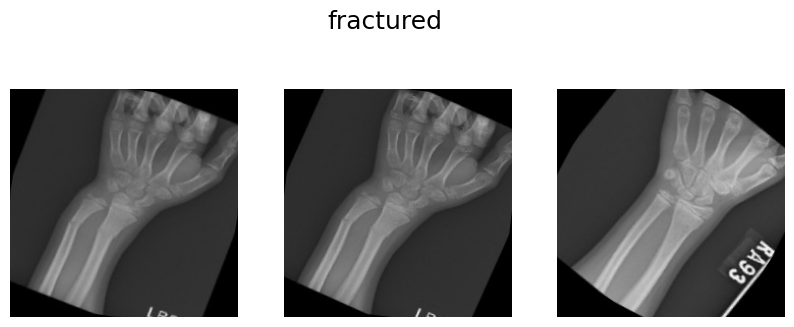

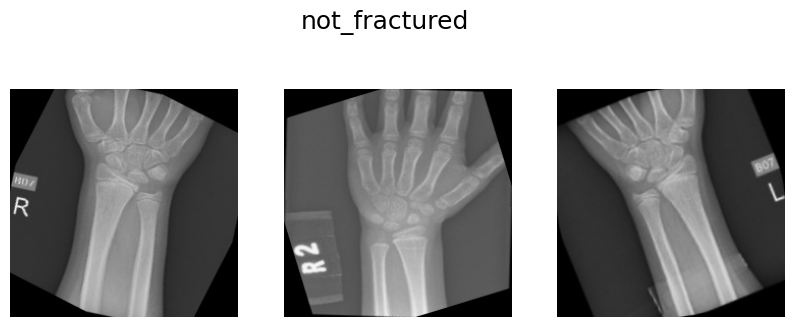

In [8]:
for category in CATEGORIES:
    path = os.path.join(DATADIR, 'testing', category)  # or 'training' if you want to visualize training images
    images = os.listdir(path)
    fig, ax = plt.subplots(1, 3, figsize=(10, 4))
    fig.suptitle(f'{category}', fontsize=18)

    for i in range(3):
        img_name = images[np.random.randint(0, len(images))]
        img_path = os.path.join(path, img_name)
        img_array = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        ax[i].imshow(img_rgb)
        ax[i].axis('off')

    plt.show()

In [9]:
import os
import cv2

# Set the dataset directory and categories
DATADIR = '/content/BoneFractureDataset/training'  # Use training directory
CATEGORIES = ['fractured', 'not_fractured']
IMG_SIZE = 224 # Set your desired image size (e.g., 100x100)

training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)  # Include the category folder (fractured/not_fractured)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # Resize image
                training_data.append([new_array, class_num])  # Append resized image and class number
            except Exception as e:
                pass  # In case of errors, just skip the image

create_training_data()
print(f"✅ Training samples: {len(training_data)}")


✅ Training samples: 8863


In [10]:
X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)

# Convert lists to NumPy arrays
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)



In [11]:
from sklearn.model_selection import train_test_split

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'✅ X_train shape: {X_train.shape}')
print(f'✅ X_val shape:   {X_val.shape}')



✅ X_train shape: (7090, 224, 224, 3)
✅ X_val shape:   (1773, 224, 224, 3)


In [12]:
# Define test data directory
TESTDIR = '/content/BoneFractureDataset/testing'

# Initialize test data list
test_data = []

def create_test_data():
    for category in CATEGORIES:
        path = os.path.join(TESTDIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                test_data.append([new_array, class_num])
            except Exception as e:
                pass

# Create the test data
create_test_data()

# Split features and labels
X_test = []
y_test = []

for features, label in test_data:
    X_test.append(features)
    y_test.append(label)

# Convert to numpy arrays
X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y_test = np.array(y_test)

# Normalize pixel values
X_test = X_test / 255.0

# Show shape
print(f'✅ X_test shape: {X_test.shape}')
print(f'✅ y_test shape: {y_test.shape}')


✅ X_test shape: (600, 224, 224, 3)
✅ y_test shape: (600,)


In [14]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (IMG_SIZE, IMG_SIZE, 3)

# Load EfficientNetB0 base model without top layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))

# Freeze base model
base_model.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Summary
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

✅ Training samples collected: 8863
Epoch 1/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 56s 143ms/step - accuracy: 0.7105 - loss: 0.5496 - val_accuracy: 0.8968 - val_loss: 0.3247
Epoch 2/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 46s 41ms/step - accuracy: 0.9034 - loss: 0.3045 - val_accuracy: 0.9459 - val_loss: 0.2155
Epoch 3/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9410 - loss: 0.2090 - val_accuracy: 0.9656 - val_loss: 0.1547
Epoch 4/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9631 - loss: 0.1491 - val_accuracy: 0.9814 - val_loss: 0.1141
Epoch 5/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9745 - loss: 0.1210 - val_accuracy: 0.9803 - val_loss: 0.0961
Epoch 6/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9790 - loss: 0.0949 - val_accuracy: 0.9859 - val_loss: 0.0750
Epoch 7/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9864 - loss: 0.0756 - val_accuracy: 0.9870 - val_loss: 0.0641
Epoch 8/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step -

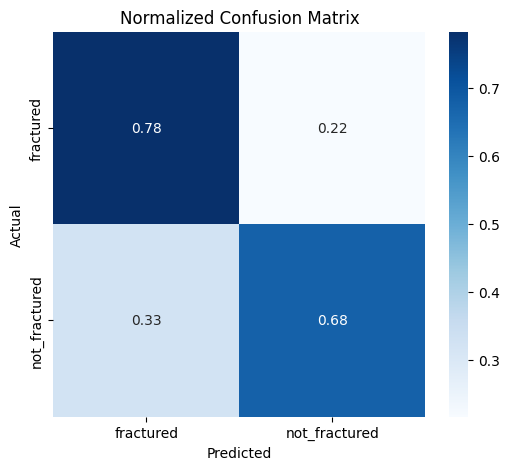


📊 Final EfficientNetB0 Summary:

 SL. No.  Sample Size  Train Dataset  Test Dataset Proposed Model    Input Size  Hidden Layer Size Neurons in Hidden Layers Activation (Hidden)  Neurons (Output Layer) Activation (Output) Optimizer       Loss Function  Epochs  Learning Rate  Execution Time (ms)  Training Accuracy  Validation Accuracy  Testing Accuracy   Loss  Validation Loss  Precision  Recall  F1-score  Classification Miss Rate  Sensitivity  Specificity  F2-score  Fβ-score (β=0.5)  Positive Predicted Value  Negative Predicted Value  False Positive Ratio  False Negative Ratio  Likelihood Positive Ratio  Likelihood Negative Ratio
       2         9463           7090           600 EfficientNetB0 (224, 224, 3)                  1                      512                relu                       1             sigmoid      Adam binary_crossentropy      10         0.0001            186289.64             0.9918               0.9932              0.74 0.0445           0.0357       0.74    0.74 

In [15]:
# ========== STEP 1: Imports ==========
import os
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, fbeta_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam

# ========== STEP 2: Prepare Data ==========
DATADIR = "/content/BoneFractureDataset/training"
CATEGORIES = ["fractured", "not_fractured"]
IMG_SIZE = 224

training_data = []
def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception:
                pass

create_training_data()
print(f"✅ Training samples collected: {len(training_data)}")

X = []
y = []
for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

# ========== STEP 3: Split Training into Train/Validation ==========
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ========== STEP 4: EfficientNetB0 Model ==========
effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in effnet.layers:
    layer.trainable = False

model = keras.Sequential([
    effnet,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# ========== STEP 5: Compile & Train ==========
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

start_train_time = time.time()
history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val)
)
exec_time = (time.time() - start_train_time) * 1000  # in ms

# ========== STEP 6: Load Test Data ==========
TEST_DIR = "BoneFractureDataset/testing"
test_data = []
for category in CATEGORIES:
    path = os.path.join(TEST_DIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([new_array, class_num])
        except Exception:
            pass

X_test = np.array([i[0] for i in test_data])
y_test = np.array([i[1] for i in test_data])

# ========== STEP 7: Evaluation ==========
loss, test_acc = model.evaluate(X_test, y_test)
y_pred_prob = model.predict(X_test).ravel()
predictions = (y_pred_prob > 0.5).astype("int32")

print("\n📌 Classification Report:\n")
print(classification_report(y_test, predictions, target_names=CATEGORIES))

# ========== Confusion Matrix ==========
cf_matrix = confusion_matrix(y_test, predictions)
cf_norm = confusion_matrix(y_test, predictions, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cf_norm, annot=True, cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ========== STEP 8: Metrics & Summary Table ==========
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]
train_loss = history.history['loss'][-1]

report = classification_report(y_test, predictions, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']
sensitivity = recall
specificity = np.mean(np.diag(cf_norm))
classification_miss_rate = 1 - test_acc

TP = np.diag(cf_matrix)
FP = np.sum(cf_matrix, axis=0) - TP
FN = np.sum(cf_matrix, axis=1) - TP
TN = np.sum(cf_matrix) - (TP + FP + FN)

PPV = TP / (TP + FP + 1e-10)
NPV = TN / (TN + FN + 1e-10)
FPR = FP / (FP + TN + 1e-10)
FNR = FN / (FN + TP + 1e-10)
LPR = PPV / (1 - FPR + 1e-10)
LNR = FNR / (1 - NPV + 1e-10)

PPV_avg = np.mean(PPV)
NPV_avg = np.mean(NPV)
FPR_avg = np.mean(FPR)
FNR_avg = np.mean(FNR)
LPR_avg = np.mean(LPR)
LNR_avg = np.mean(LNR)

f2 = fbeta_score(y_test, predictions, beta=2, average='weighted')
fbeta_custom = fbeta_score(y_test, predictions, beta=0.5, average='weighted')

# ========== STEP 9: Result Table ==========
result = {
    "SL. No.": 2,
    "Sample Size": len(X) + len(X_test),
    "Train Dataset": len(X_train),
    "Test Dataset": len(X_test),
    "Proposed Model": "EfficientNetB0",
    "Input Size": X_train.shape[1:4],
    "Hidden Layer Size": 1,
    "Neurons in Hidden Layers": "512",
    "Activation (Hidden)": "relu",
    "Neurons (Output Layer)": 1,
    "Activation (Output)": "sigmoid",
    "Optimizer": "Adam",
    "Loss Function": "binary_crossentropy",
    "Epochs": 10,
    "Learning Rate": 0.0001,
    "Execution Time (ms)": round(exec_time, 2),
    "Training Accuracy": round(train_acc, 4),
    "Validation Accuracy": round(val_acc, 4),
    "Testing Accuracy": round(test_acc, 4),
    "Loss": round(train_loss, 4),
    "Validation Loss": round(val_loss, 4),
    "Precision": round(precision, 4),
    "Recall": round(recall, 4),
    "F1-score": round(f1, 4),
    "Classification Miss Rate": round(classification_miss_rate, 4),
    "Sensitivity": round(sensitivity, 4),
    "Specificity": round(specificity, 4),
    "F2-score": round(f2, 4),
    "Fβ-score (β=0.5)": round(fbeta_custom, 4),
    "Positive Predicted Value": round(PPV_avg, 4),
    "Negative Predicted Value": round(NPV_avg, 4),
    "False Positive Ratio": round(FPR_avg, 4),
    "False Negative Ratio": round(FNR_avg, 4),
    "Likelihood Positive Ratio": round(LPR_avg, 4),
    "Likelihood Negative Ratio": round(LNR_avg, 4),
}

df_result = pd.DataFrame([result])
print("\n📊 Final EfficientNetB0 Summary:\n")
print(df_result.to_string(index=False))


✅ Training samples collected: 8863
Epoch 1/5
222/222 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.7916 - loss: 0.4226 - val_accuracy: 0.9679 - val_loss: 0.1030
Epoch 2/5
222/222 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9677 - loss: 0.1006 - val_accuracy: 0.9938 - val_loss: 0.0301
Epoch 3/5
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.9879 - loss: 0.0430 - val_accuracy: 0.9966 - val_loss: 0.0193
Epoch 4/5
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9928 - loss: 0.0287 - val_accuracy: 0.9938 - val_loss: 0.0189
Epoch 5/5
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9947 - loss: 0.0217 - val_accuracy: 0.9977 - val_loss: 0.0104
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step - accuracy: 0.8004 - loss: 0.7979
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 414ms/step

📌 Classification Report:

               precision    recall  f1-score   support

    fractured       0.78      0.80      0.79       360
not_fractured       0.69      0.66      0.68       240

     accur

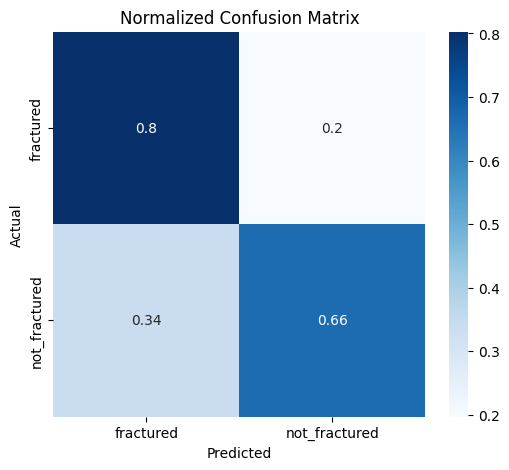


📊 Final EfficientNetB0 Summary:

 SL. No.  Sample Size  Train Dataset  Test Dataset Proposed Model    Input Size  Hidden Layer Size Neurons in Hidden Layers Activation (Hidden)  Neurons (Output Layer) Activation (Output) Optimizer       Loss Function  Epochs  Learning Rate  Execution Time (ms)  Training Accuracy  Validation Accuracy  Testing Accuracy   Loss  Validation Loss  Precision  Recall  F1-score  Classification Miss Rate  Sensitivity  Specificity  F2-score  Fβ-score (β=0.5)  Positive Predicted Value  Negative Predicted Value  False Positive Ratio  False Negative Ratio  Likelihood Positive Ratio  Likelihood Negative Ratio
       2         9463           7090           600 EfficientNetB0 (224, 224, 3)                  1                      512                relu                       1             sigmoid      Adam binary_crossentropy       5          0.001              94312.7             0.9946               0.9977            0.7467 0.0203           0.0104     0.7452  0.7467 

In [16]:
# ========== STEP 1: Imports ==========
import os
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, fbeta_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam

# ========== STEP 2: Prepare Data ==========
DATADIR = "/content/BoneFractureDataset/training"
CATEGORIES = ["fractured", "not_fractured"]
IMG_SIZE = 224

training_data = []
def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception:
                pass

create_training_data()
print(f"✅ Training samples collected: {len(training_data)}")

X = []
y = []
for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

# ========== STEP 3: Split Training into Train/Validation ==========
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ========== STEP 4: EfficientNetB0 Model ==========
effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in effnet.layers:
    layer.trainable = False

model = keras.Sequential([
    effnet,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# ========== STEP 5: Compile & Train ==========
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

start_train_time = time.time()
history = model.fit(
    X_train, y_train,
    epochs=5,
    validation_data=(X_val, y_val)
)
exec_time = (time.time() - start_train_time) * 1000  # in ms

# ========== STEP 6: Load Test Data ==========
TEST_DIR = "BoneFractureDataset/testing"
test_data = []
for category in CATEGORIES:
    path = os.path.join(TEST_DIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([new_array, class_num])
        except Exception:
            pass

X_test = np.array([i[0] for i in test_data])
y_test = np.array([i[1] for i in test_data])

# ========== STEP 7: Evaluation ==========
loss, test_acc = model.evaluate(X_test, y_test)
y_pred_prob = model.predict(X_test).ravel()
predictions = (y_pred_prob > 0.5).astype("int32")

print("\n📌 Classification Report:\n")
print(classification_report(y_test, predictions, target_names=CATEGORIES))

# ========== Confusion Matrix ==========
cf_matrix = confusion_matrix(y_test, predictions)
cf_norm = confusion_matrix(y_test, predictions, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cf_norm, annot=True, cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ========== STEP 8: Metrics & Summary Table ==========
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]
train_loss = history.history['loss'][-1]

report = classification_report(y_test, predictions, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']
sensitivity = recall
specificity = np.mean(np.diag(cf_norm))
classification_miss_rate = 1 - test_acc

TP = np.diag(cf_matrix)
FP = np.sum(cf_matrix, axis=0) - TP
FN = np.sum(cf_matrix, axis=1) - TP
TN = np.sum(cf_matrix) - (TP + FP + FN)

PPV = TP / (TP + FP + 1e-10)
NPV = TN / (TN + FN + 1e-10)
FPR = FP / (FP + TN + 1e-10)
FNR = FN / (FN + TP + 1e-10)
LPR = PPV / (1 - FPR + 1e-10)
LNR = FNR / (1 - NPV + 1e-10)

PPV_avg = np.mean(PPV)
NPV_avg = np.mean(NPV)
FPR_avg = np.mean(FPR)
FNR_avg = np.mean(FNR)
LPR_avg = np.mean(LPR)
LNR_avg = np.mean(LNR)

f2 = fbeta_score(y_test, predictions, beta=2, average='weighted')
fbeta_custom = fbeta_score(y_test, predictions, beta=0.5, average='weighted')

# ========== STEP 9: Result Table ==========
result = {
    "SL. No.": 2,
    "Sample Size": len(X) + len(X_test),
    "Train Dataset": len(X_train),
    "Test Dataset": len(X_test),
    "Proposed Model": "EfficientNetB0",
    "Input Size": X_train.shape[1:4],
    "Hidden Layer Size": 1,
    "Neurons in Hidden Layers": "512",
    "Activation (Hidden)": "relu",
    "Neurons (Output Layer)": 1,
    "Activation (Output)": "sigmoid",
    "Optimizer": "Adam",
    "Loss Function": "binary_crossentropy",
    "Epochs": 5,
    "Learning Rate": 0.001,
    "Execution Time (ms)": round(exec_time, 2),
    "Training Accuracy": round(train_acc, 4),
    "Validation Accuracy": round(val_acc, 4),
    "Testing Accuracy": round(test_acc, 4),
    "Loss": round(train_loss, 4),
    "Validation Loss": round(val_loss, 4),
    "Precision": round(precision, 4),
    "Recall": round(recall, 4),
    "F1-score": round(f1, 4),
    "Classification Miss Rate": round(classification_miss_rate, 4),
    "Sensitivity": round(sensitivity, 4),
    "Specificity": round(specificity, 4),
    "F2-score": round(f2, 4),
    "Fβ-score (β=0.5)": round(fbeta_custom, 4),
    "Positive Predicted Value": round(PPV_avg, 4),
    "Negative Predicted Value": round(NPV_avg, 4),
    "False Positive Ratio": round(FPR_avg, 4),
    "False Negative Ratio": round(FNR_avg, 4),
    "Likelihood Positive Ratio": round(LPR_avg, 4),
    "Likelihood Negative Ratio": round(LNR_avg, 4),
}

df_result = pd.DataFrame([result])
print("\n📊 Final EfficientNetB0 Summary:\n")
print(df_result.to_string(index=False))


✅ Training samples collected: 8863
Epoch 1/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 50s 133ms/step - accuracy: 0.7520 - loss: 0.8477 - val_accuracy: 0.9616 - val_loss: 0.1164
Epoch 2/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.9550 - loss: 0.1096 - val_accuracy: 0.9763 - val_loss: 0.0513
Epoch 3/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9775 - loss: 0.0557 - val_accuracy: 0.9780 - val_loss: 0.0537
Epoch 4/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9831 - loss: 0.0505 - val_accuracy: 0.9932 - val_loss: 0.0236
Epoch 5/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9893 - loss: 0.0315 - val_accuracy: 0.9944 - val_loss: 0.0236
Epoch 6/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9884 - loss: 0.0337 - val_accuracy: 0.9848 - val_loss: 0.0398
Epoch 7/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.9880 - loss: 0.0376 - val_accuracy: 0.9391 - val_loss: 0.2084
Epoch 8/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - a

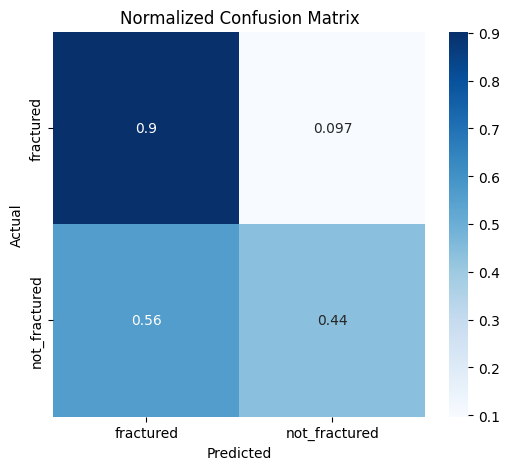


📊 Final EfficientNetB0 Summary:

 SL. No.  Sample Size  Train Dataset  Test Dataset Proposed Model    Input Size  Hidden Layer Size Neurons in Hidden Layers Activation (Hidden)  Neurons (Output Layer) Activation (Output) Optimizer       Loss Function  Epochs  Learning Rate  Execution Time (ms)  Training Accuracy  Validation Accuracy  Testing Accuracy   Loss  Validation Loss  Precision  Recall  F1-score  Classification Miss Rate  Sensitivity  Specificity  F2-score  Fβ-score (β=0.5)  Positive Predicted Value  Negative Predicted Value  False Positive Ratio  False Negative Ratio  Likelihood Positive Ratio  Likelihood Negative Ratio
       2         9463           7090           600 EfficientNetB0 (224, 224, 3)                  1                      512                relu                       1             sigmoid      Adam binary_crossentropy      15           0.01            202543.07             0.9937               0.9921            0.7167 0.0176           0.0256     0.7239  0.7167 

In [17]:
# ========== STEP 1: Imports ==========
import os
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, fbeta_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam

# ========== STEP 2: Prepare Data ==========
DATADIR = "/content/BoneFractureDataset/training"
CATEGORIES = ["fractured", "not_fractured"]
IMG_SIZE = 224

training_data = []
def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception:
                pass

create_training_data()
print(f"✅ Training samples collected: {len(training_data)}")

X = []
y = []
for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

# ========== STEP 3: Split Training into Train/Validation ==========
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ========== STEP 4: EfficientNetB0 Model ==========
effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in effnet.layers:
    layer.trainable = False

model = keras.Sequential([
    effnet,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# ========== STEP 5: Compile & Train ==========
model.compile(optimizer=Adam(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

start_train_time = time.time()
history = model.fit(
    X_train, y_train,
    epochs=15,
    validation_data=(X_val, y_val)
)
exec_time = (time.time() - start_train_time) * 1000  # in ms

# ========== STEP 6: Load Test Data ==========
TEST_DIR = "BoneFractureDataset/testing"
test_data = []
for category in CATEGORIES:
    path = os.path.join(TEST_DIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([new_array, class_num])
        except Exception:
            pass

X_test = np.array([i[0] for i in test_data])
y_test = np.array([i[1] for i in test_data])

# ========== STEP 7: Evaluation ==========
loss, test_acc = model.evaluate(X_test, y_test)
y_pred_prob = model.predict(X_test).ravel()
predictions = (y_pred_prob > 0.5).astype("int32")

print("\n📌 Classification Report:\n")
print(classification_report(y_test, predictions, target_names=CATEGORIES))

# ========== Confusion Matrix ==========
cf_matrix = confusion_matrix(y_test, predictions)
cf_norm = confusion_matrix(y_test, predictions, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cf_norm, annot=True, cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ========== STEP 8: Metrics & Summary Table ==========
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]
train_loss = history.history['loss'][-1]

report = classification_report(y_test, predictions, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']
sensitivity = recall
specificity = np.mean(np.diag(cf_norm))
classification_miss_rate = 1 - test_acc

TP = np.diag(cf_matrix)
FP = np.sum(cf_matrix, axis=0) - TP
FN = np.sum(cf_matrix, axis=1) - TP
TN = np.sum(cf_matrix) - (TP + FP + FN)

PPV = TP / (TP + FP + 1e-10)
NPV = TN / (TN + FN + 1e-10)
FPR = FP / (FP + TN + 1e-10)
FNR = FN / (FN + TP + 1e-10)
LPR = PPV / (1 - FPR + 1e-10)
LNR = FNR / (1 - NPV + 1e-10)

PPV_avg = np.mean(PPV)
NPV_avg = np.mean(NPV)
FPR_avg = np.mean(FPR)
FNR_avg = np.mean(FNR)
LPR_avg = np.mean(LPR)
LNR_avg = np.mean(LNR)

f2 = fbeta_score(y_test, predictions, beta=2, average='weighted')
fbeta_custom = fbeta_score(y_test, predictions, beta=0.5, average='weighted')

# ========== STEP 9: Result Table ==========
result = {
    "SL. No.": 2,
    "Sample Size": len(X) + len(X_test),
    "Train Dataset": len(X_train),
    "Test Dataset": len(X_test),
    "Proposed Model": "EfficientNetB0",
    "Input Size": X_train.shape[1:4],
    "Hidden Layer Size": 1,
    "Neurons in Hidden Layers": "512",
    "Activation (Hidden)": "relu",
    "Neurons (Output Layer)": 1,
    "Activation (Output)": "sigmoid",
    "Optimizer": "Adam",
    "Loss Function": "binary_crossentropy",
    "Epochs": 15,
    "Learning Rate": 0.01,
    "Execution Time (ms)": round(exec_time, 2),
    "Training Accuracy": round(train_acc, 4),
    "Validation Accuracy": round(val_acc, 4),
    "Testing Accuracy": round(test_acc, 4),
    "Loss": round(train_loss, 4),
    "Validation Loss": round(val_loss, 4),
    "Precision": round(precision, 4),
    "Recall": round(recall, 4),
    "F1-score": round(f1, 4),
    "Classification Miss Rate": round(classification_miss_rate, 4),
    "Sensitivity": round(sensitivity, 4),
    "Specificity": round(specificity, 4),
    "F2-score": round(f2, 4),
    "Fβ-score (β=0.5)": round(fbeta_custom, 4),
    "Positive Predicted Value": round(PPV_avg, 4),
    "Negative Predicted Value": round(NPV_avg, 4),
    "False Positive Ratio": round(FPR_avg, 4),
    "False Negative Ratio": round(FNR_avg, 4),
    "Likelihood Positive Ratio": round(LPR_avg, 4),
    "Likelihood Negative Ratio": round(LNR_avg, 4),
}

df_result = pd.DataFrame([result])
print("\n📊 Final EfficientNetB0 Summary:\n")
print(df_result.to_string(index=False))


✅ Training samples collected: 8863
Epoch 1/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 52s 135ms/step - accuracy: 0.7968 - loss: 0.4125 - val_accuracy: 0.9763 - val_loss: 0.0911
Epoch 2/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9780 - loss: 0.0826 - val_accuracy: 0.9915 - val_loss: 0.0412
Epoch 3/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9880 - loss: 0.0435 - val_accuracy: 0.9915 - val_loss: 0.0303
Epoch 4/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9964 - loss: 0.0232 - val_accuracy: 0.9949 - val_loss: 0.0158
Epoch 5/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9938 - loss: 0.0234 - val_accuracy: 0.9977 - val_loss: 0.0103
Epoch 6/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.9946 - loss: 0.0185 - val_accuracy: 0.9944 - val_loss: 0.0193
Epoch 7/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.9955 - loss: 0.0144 - val_accuracy: 0.9966 - val_loss: 0.0111
Epoch 8/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - a

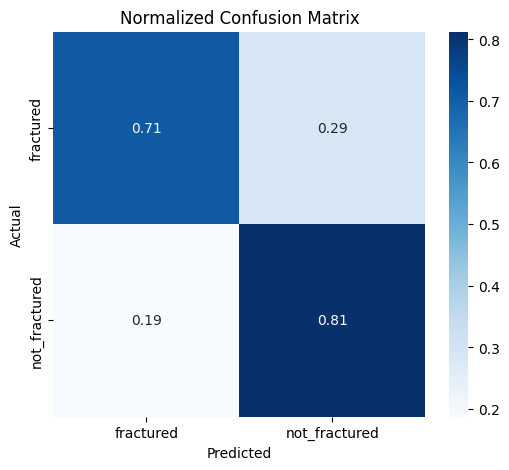


📊 Final EfficientNetB0 Summary:

 SL. No.  Sample Size  Train Dataset  Test Dataset Proposed Model    Input Size  Hidden Layer Size Neurons in Hidden Layers Activation (Hidden)  Neurons (Output Layer) Activation (Output) Optimizer       Loss Function  Epochs  Learning Rate  Execution Time (ms)  Training Accuracy  Validation Accuracy  Testing Accuracy  Loss  Validation Loss  Precision  Recall  F1-score  Classification Miss Rate  Sensitivity  Specificity  F2-score  Fβ-score (β=0.5)  Positive Predicted Value  Negative Predicted Value  False Positive Ratio  False Negative Ratio  Likelihood Positive Ratio  Likelihood Negative Ratio
       2         9463           7090           600 EfficientNetB0 (224, 224, 3)                  1                      512                relu                       1             sigmoid      Adam binary_crossentropy      10          0.001            142160.33             0.9945               0.9904            0.7517 0.014           0.0299     0.7712  0.7517   

In [18]:
# ========== STEP 1: Imports ==========
import os
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, fbeta_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam

# ========== STEP 2: Prepare Data ==========
DATADIR = "/content/BoneFractureDataset/training"
CATEGORIES = ["fractured", "not_fractured"]
IMG_SIZE = 224

training_data = []
def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception:
                pass

create_training_data()
print(f"✅ Training samples collected: {len(training_data)}")

X = []
y = []
for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

# ========== STEP 3: Split Training into Train/Validation ==========
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ========== STEP 4: EfficientNetB0 Model ==========
effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in effnet.layers:
    layer.trainable = False

model = keras.Sequential([
    effnet,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# ========== STEP 5: Compile & Train ==========
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

start_train_time = time.time()
history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val)
)
exec_time = (time.time() - start_train_time) * 1000  # in ms

# ========== STEP 6: Load Test Data ==========
TEST_DIR = "BoneFractureDataset/testing"
test_data = []
for category in CATEGORIES:
    path = os.path.join(TEST_DIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([new_array, class_num])
        except Exception:
            pass

X_test = np.array([i[0] for i in test_data])
y_test = np.array([i[1] for i in test_data])

# ========== STEP 7: Evaluation ==========
loss, test_acc = model.evaluate(X_test, y_test)
y_pred_prob = model.predict(X_test).ravel()
predictions = (y_pred_prob > 0.5).astype("int32")

print("\n📌 Classification Report:\n")
print(classification_report(y_test, predictions, target_names=CATEGORIES))

# ========== Confusion Matrix ==========
cf_matrix = confusion_matrix(y_test, predictions)
cf_norm = confusion_matrix(y_test, predictions, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cf_norm, annot=True, cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ========== STEP 8: Metrics & Summary Table ==========
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]
train_loss = history.history['loss'][-1]

report = classification_report(y_test, predictions, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']
sensitivity = recall
specificity = np.mean(np.diag(cf_norm))
classification_miss_rate = 1 - test_acc

TP = np.diag(cf_matrix)
FP = np.sum(cf_matrix, axis=0) - TP
FN = np.sum(cf_matrix, axis=1) - TP
TN = np.sum(cf_matrix) - (TP + FP + FN)

PPV = TP / (TP + FP + 1e-10)
NPV = TN / (TN + FN + 1e-10)
FPR = FP / (FP + TN + 1e-10)
FNR = FN / (FN + TP + 1e-10)
LPR = PPV / (1 - FPR + 1e-10)
LNR = FNR / (1 - NPV + 1e-10)

PPV_avg = np.mean(PPV)
NPV_avg = np.mean(NPV)
FPR_avg = np.mean(FPR)
FNR_avg = np.mean(FNR)
LPR_avg = np.mean(LPR)
LNR_avg = np.mean(LNR)

f2 = fbeta_score(y_test, predictions, beta=2, average='weighted')
fbeta_custom = fbeta_score(y_test, predictions, beta=0.5, average='weighted')

# ========== STEP 9: Result Table ==========
result = {
    "SL. No.": 2,
    "Sample Size": len(X) + len(X_test),
    "Train Dataset": len(X_train),
    "Test Dataset": len(X_test),
    "Proposed Model": "EfficientNetB0",
    "Input Size": X_train.shape[1:4],
    "Hidden Layer Size": 1,
    "Neurons in Hidden Layers": "512",
    "Activation (Hidden)": "relu",
    "Neurons (Output Layer)": 1,
    "Activation (Output)": "sigmoid",
    "Optimizer": "Adam",
    "Loss Function": "binary_crossentropy",
    "Epochs": 10,
    "Learning Rate": 0.001,
    "Execution Time (ms)": round(exec_time, 2),
    "Training Accuracy": round(train_acc, 4),
    "Validation Accuracy": round(val_acc, 4),
    "Testing Accuracy": round(test_acc, 4),
    "Loss": round(train_loss, 4),
    "Validation Loss": round(val_loss, 4),
    "Precision": round(precision, 4),
    "Recall": round(recall, 4),
    "F1-score": round(f1, 4),
    "Classification Miss Rate": round(classification_miss_rate, 4),
    "Sensitivity": round(sensitivity, 4),
    "Specificity": round(specificity, 4),
    "F2-score": round(f2, 4),
    "Fβ-score (β=0.5)": round(fbeta_custom, 4),
    "Positive Predicted Value": round(PPV_avg, 4),
    "Negative Predicted Value": round(NPV_avg, 4),
    "False Positive Ratio": round(FPR_avg, 4),
    "False Negative Ratio": round(FNR_avg, 4),
    "Likelihood Positive Ratio": round(LPR_avg, 4),
    "Likelihood Negative Ratio": round(LNR_avg, 4),
}

df_result = pd.DataFrame([result])
print("\n📊 Final EfficientNetB0 Summary:\n")
print(df_result.to_string(index=False))


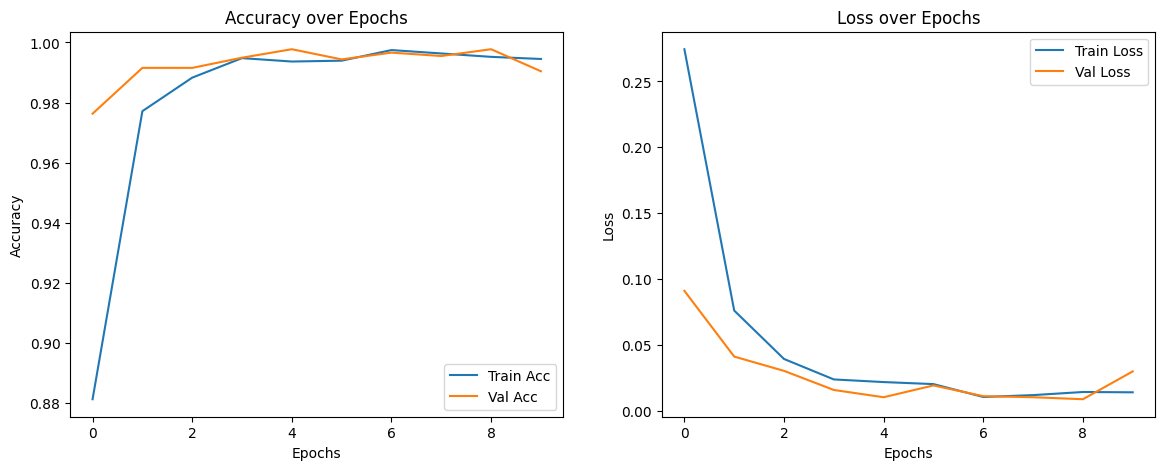

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


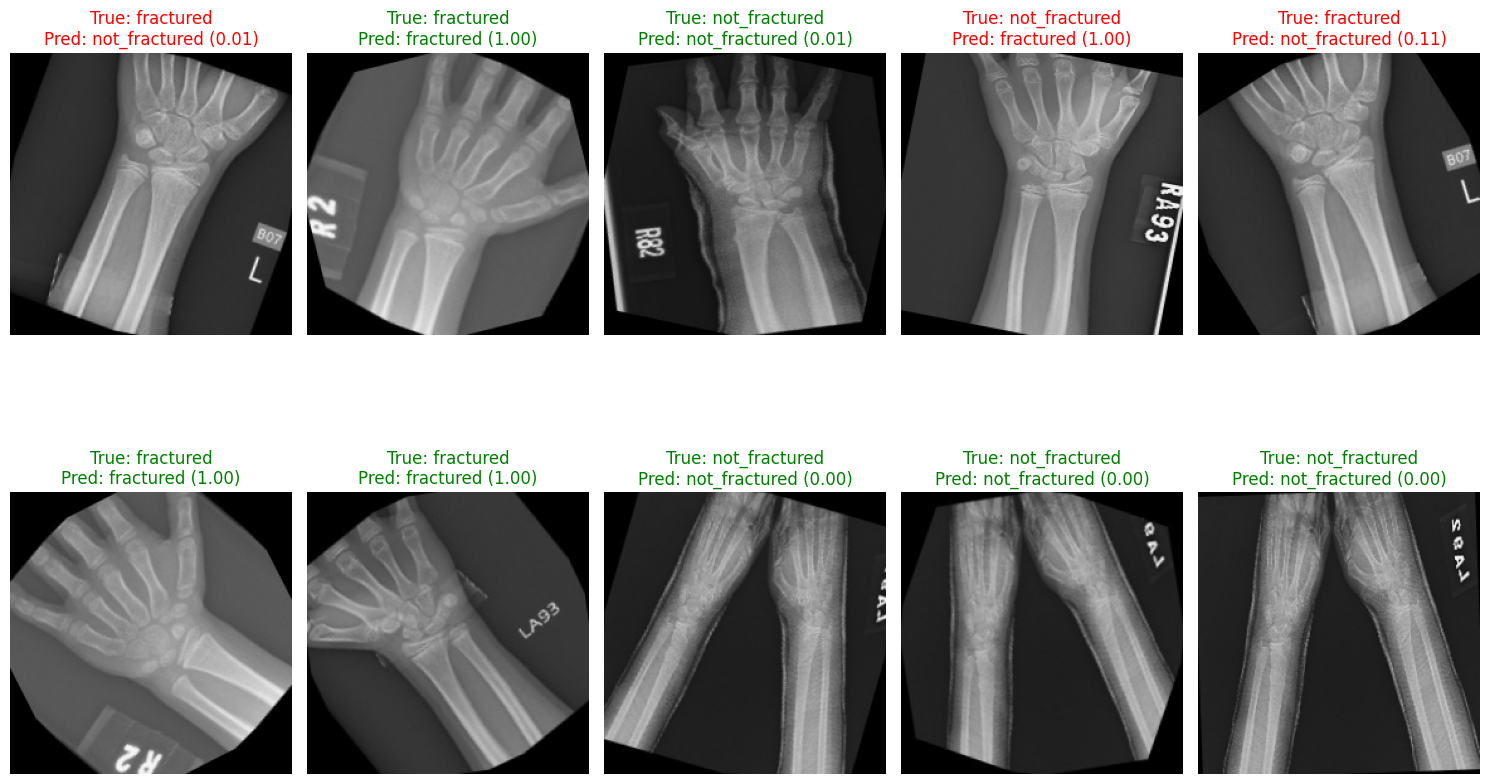

In [20]:
import random

# Map class index to label
class_labels = {0: "not_fractured", 1: "fractured"}

# Predict probabilities
y_probs = model.predict(X_test)
y_preds = (y_probs > 0.5).astype("int32").flatten()

# Show 10 random test images with predictions
plt.figure(figsize=(15, 10))

for i in range(10):
    idx = random.randint(0, len(X_test) - 1)
    img = X_test[idx]
    true_label = class_labels[y_test[idx]]
    predicted_label = class_labels[y_preds[idx]]
    prob = y_probs[idx][0]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img.astype("uint8"))
    plt.title(f"True: {true_label}\nPred: {predicted_label} ({prob:.2f})",
              color="green" if true_label == predicted_label else "red")
    plt.axis('off')

plt.tight_layout()
plt.show()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step

❌ Total wrong predictions: 149


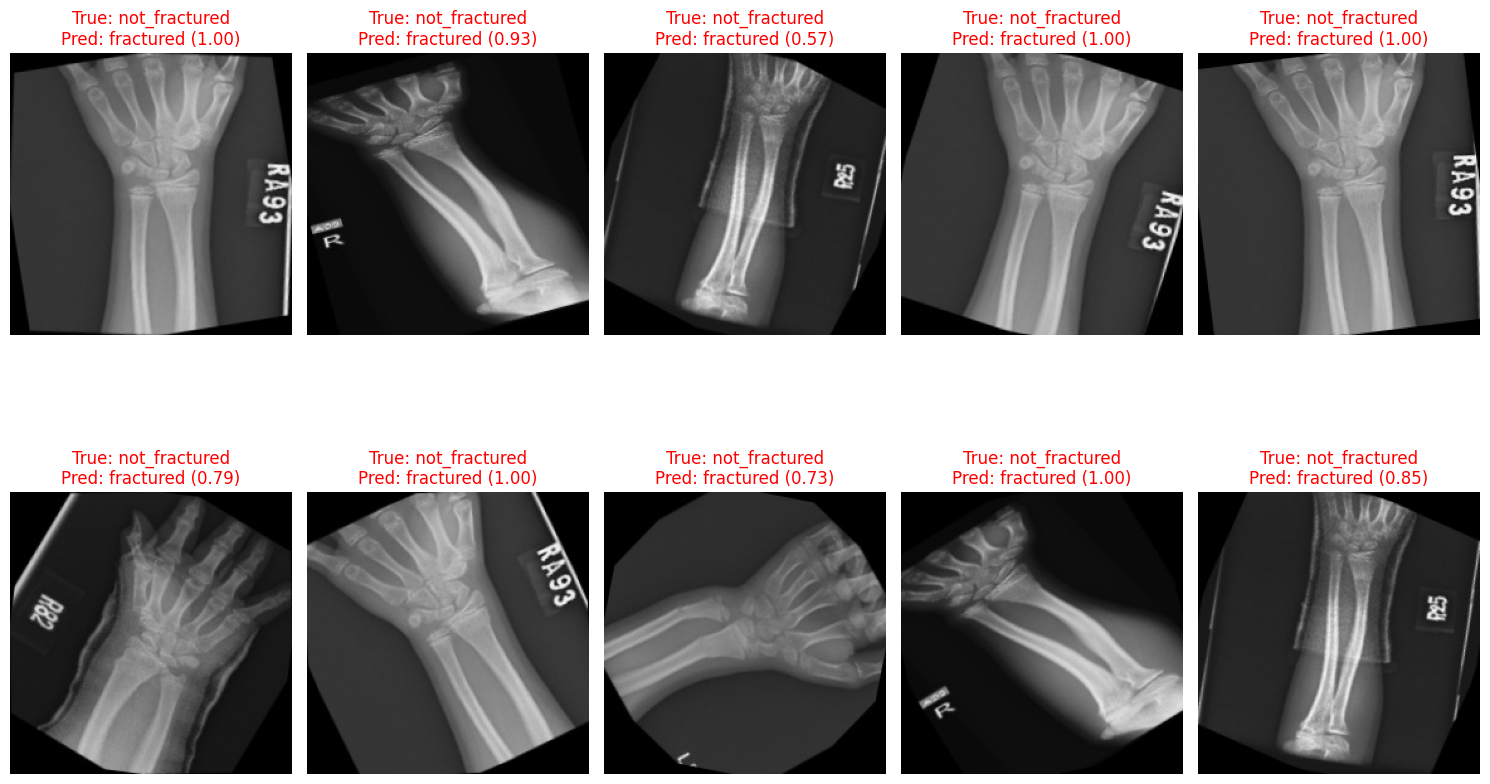

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Predict on test data
y_probs = model.predict(X_test)
y_preds = (y_probs > 0.5).astype("int32").flatten()

# Define label mapping
class_labels = {0: "not_fractured", 1: "fractured"}

# Find indices of incorrect predictions
wrong_indices = np.where(y_preds != y_test)[0]

print(f"\n❌ Total wrong predictions: {len(wrong_indices)}")

# Display some wrongly predicted images
plt.figure(figsize=(15, 10))

for i, idx in enumerate(wrong_indices[:10]):  # Show first 10 wrong predictions
    img = X_test[idx]
    true_label = class_labels[y_test[idx]]
    predicted_label = class_labels[y_preds[idx]]
    prob = y_probs[idx][0]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img.astype("uint8"))
    plt.title(f"True: {true_label}\nPred: {predicted_label} ({prob:.2f})", color="red")
    plt.axis('off')

plt.tight_layout()
plt.show()


## **END OF EfficientNetB0**